 # 餐廳評論情緒分析（使用Transformers模型）

 使用預訓練的中文BERT模型進行情緒分析

In [1]:
# 匯入必要套件
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline
import torch
from typing import Optional
from transformers.models.auto.tokenization_auto import AutoTokenizer
from transformers.models.auto.modeling_auto import AutoModelForSequenceClassification


 ## 設定環境

In [2]:
# 設定中文字型避免亂碼
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 輸出 SVG 圖片
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


 ## 資料匯入與前處理

In [3]:
# 讀取Excel資料
df = pd.read_excel("data/restaurant-comments1.xlsx")
df.head()


,留言內容,留言時間
0,这辈子最爱吃的火锅，一星期必吃一次啊！最近才知道他家还有免费鸡蛋羹………………炒鸡好吃炒鸡嫩...,2017-05-14 16:00:00
1,第N次来了，还是喜欢?……<br><br>从还没上A餐厅的楼梯开始，服务员已经在那迎宾了，然...,2017-05-10 16:00:00
2,大姨过生日，姐姐定的这家A餐厅的包间，服务真的是没得说，A餐厅的服务也是让我由衷的欣赏，很久...,2017-04-20 16:00:00
3,A餐厅的服务哪家店都一样，体贴入微。这家店是我吃过的排队最短的一家，当然也介于工作日且比较晚...,2017-04-25 16:00:00
4,因为下午要去天津站接人，然后我倩前几天就说想吃A餐厅，然后正好这有，就来这吃了。<br>来的...,2017-05-21 16:00:00


In [4]:
# 資料清理：日期格式轉換與移除空值
df["留言時間"] = pd.to_datetime(df["留言時間"])
df.dropna(subset=["留言內容"], inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   留言內容    27 non-null     object        
 1   留言時間    27 non-null     datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 564.0+ bytes


 ## 載入預訓練的中文情緒分析模型

In [5]:
# 指定使用京東評論情緒分析模型
model_name = "uer/roberta-base-finetuned-jd-binary-chinese"

# 載入tokenizer和模型
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 顯示模型資訊
print(f"已成功載入 {model_name} 模型")
print(f"模型類型: {type(model).__name__}")
print(f"Tokenizer類型: {type(tokenizer).__name__}")


已成功載入 uer/roberta-base-finetuned-jd-binary-chinese 模型
模型類型: BertForSequenceClassification
Tokenizer類型: BertTokenizerFast


 ## 實作情緒分析函式

In [6]:
from transformers.pipelines import pipeline

# 重新映射標籤
model.config.id2label = {0: "NEGATIVE", 1: "POSITIVE"}
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Device set to use mps:0


 ## 對留言進行情緒分析

In [7]:
classified = classifier(list(df["留言內容"]))
assert isinstance(classified, list)
assert len(classified) == len(df)

classified = [result["label"] for result in classified]
df["sentiment_label"] = classified

In [8]:
# 顯示情緒分布統計
print("情緒分布統計：")
sentiment_counts = df["sentiment_label"].value_counts()
print(sentiment_counts)

# 計算百分比
sentiment_percentage = df["sentiment_label"].value_counts(normalize=True) * 100
print("\n情緒分布百分比：")
for label, percentage in sentiment_percentage.items():
    print(f"{label}: {percentage:.2f}%")


情緒分布統計：
sentiment_label
POSITIVE    27
Name: count, dtype: int64

情緒分布百分比：
POSITIVE: 100.00%


 ## 視覺化分析

 ### 每日正向與負向留言筆數

In [9]:
# 按日期和情緒標籤分組計算留言數量
daily_count = df.groupby([df["留言時間"].dt.date, "sentiment_label"]).size().unstack().fillna(0)
daily_count.head()


sentiment_label,POSITIVE
留言時間,
2017-02-20,1
2017-03-16,1
2017-03-17,1
2017-04-10,1
2017-04-14,2


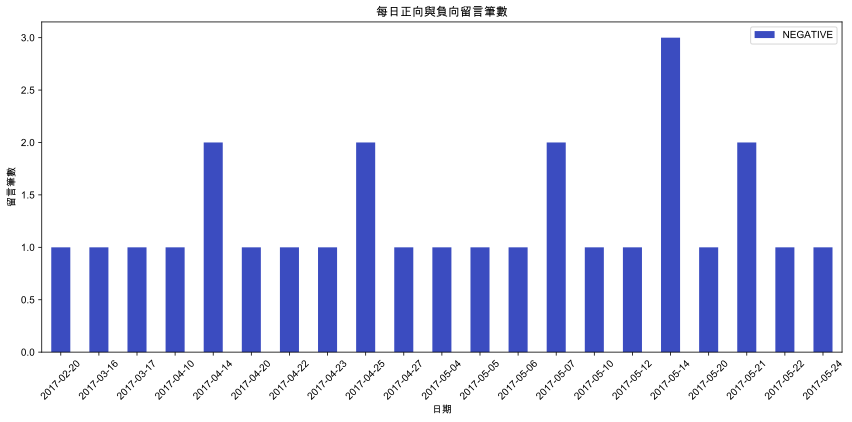

In [10]:
# 繪製每日情緒筆數長條圖
ax = daily_count.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("每日正向與負向留言筆數")
plt.ylabel("留言筆數")
plt.xlabel("日期")
plt.xticks(rotation=45)
plt.legend(["NEGATIVE", "POSITIVE"])

# 新增數值標籤
for i, v in enumerate(daily_count.values):
    pos_count = v[1] if len(v) > 1 and "POSITIVE" in daily_count.columns else 0
    neg_count = v[0] if "NEGATIVE" in daily_count.columns else 0
    
    # 顯示正向標籤
    if pos_count > 0:
        plt.text(i, neg_count + pos_count/2, f"{int(pos_count)}", 
                 ha='center', va='center', color='white', fontweight='bold')
    
    # 顯示負向標籤
    if neg_count > 0:
        plt.text(i, neg_count/2, f"{int(neg_count)}", 
                 ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()


 ### 每月正向與負向留言筆數

In [11]:
# 按月份和情緒標籤分組計算留言數量
monthly_count = df.groupby([df["留言時間"].dt.to_period("M"), "sentiment_label"]).size().unstack().fillna(0)
monthly_count.index = monthly_count.index.to_timestamp()
monthly_count


sentiment_label,POSITIVE
留言時間,
2017-02-01,1
2017-03-01,2
2017-04-01,9
2017-05-01,15


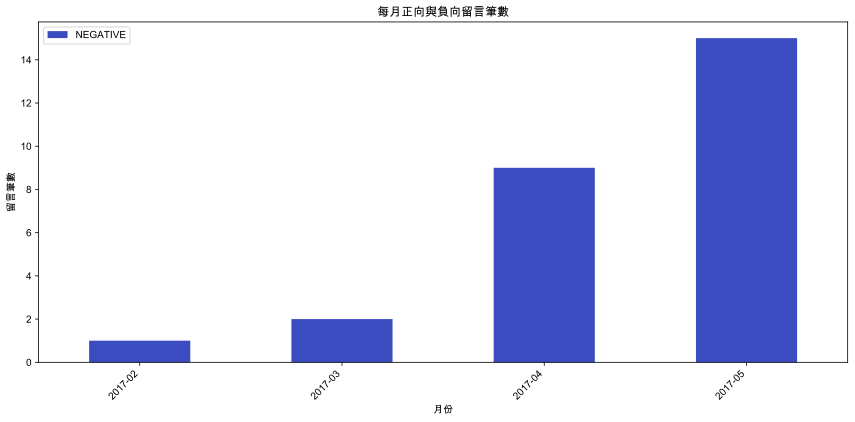

In [12]:
# 繪製每月情緒筆數長條圖
ax = monthly_count.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("每月正向與負向留言筆數")
plt.ylabel("留言筆數")
plt.xlabel("月份")
plt.xticks(rotation=45, ha='right', ticks=range(len(monthly_count.index)), 
           labels=[x.strftime("%Y-%m") for x in monthly_count.index])

# 修正圖例顯示順序
handles, labels = ax.get_legend_handles_labels()
if "NEGATIVE" in monthly_count.columns and "POSITIVE" in monthly_count.columns:
    plt.legend(handles, labels)
else:
    plt.legend(["NEGATIVE", "POSITIVE"])

# 新增數值標籤
for i, v in enumerate(monthly_count.values):
    pos_count = v[1] if len(v) > 1 and "POSITIVE" in monthly_count.columns else 0
    neg_count = v[0] if "NEGATIVE" in monthly_count.columns else 0
    
    # 顯示正向標籤
    if pos_count > 0:
        plt.text(i, neg_count + pos_count/2, f"{int(pos_count)}", 
                 ha='center', va='center', color='white', fontweight='bold')
    
    # 顯示負向標籤
    if neg_count > 0:
        plt.text(i, neg_count/2, f"{int(neg_count)}", 
                 ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()


 ## 練習：PTT運動內衣評論情緒分析

In [13]:
# 載入PTT運動內衣資料
ptt_df = pd.read_csv("data/PTT_運動內衣_onepage資料留言內容.csv")
ptt_df.head()


,Unnamed: 0,type,user,content,ipdatetime
0,0,推,yalisa61037,美美的,02/23 23:52
1,1,推,wenyu66,真的都很美欸 不能再看了嗚嗚嗚 好想買,02/24 00:23
2,2,推,sd929598,感覺穿起來會刺刺的,02/24 01:27
3,3,推,mocc,*\(^o^)/*,02/24 09:23
4,4,推,Valentine17,樓樓上sd 大 莎露的蕾絲真的穿起來不會刺！這大概也,02/24 12:15


In [14]:
# 移除空值
ptt_df.dropna(subset=["content"], inplace=True)

# 對留言內容進行情緒分析
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
classified = classifier(list(ptt_df["content"]))
assert isinstance(classified, list)
assert len(classified) == len(ptt_df)

classified = [result["label"] for result in classified]
ptt_df["sentiment_label"] = classified

# 移除分析失敗的資料
ptt_df.dropna(subset=["sentiment_label"], inplace=True)


Device set to use mps:0


In [15]:
# 情緒分布統計
print("PTT運動內衣留言情緒分布：")
ptt_sentiment_counts = ptt_df["sentiment_label"].value_counts()
print(ptt_sentiment_counts)

# 計算百分比
ptt_sentiment_percentage = ptt_df["sentiment_label"].value_counts(normalize=True) * 100
print("\n情緒分布百分比：")
for label, percentage in ptt_sentiment_percentage.items():
    print(f"{label}: {percentage:.2f}%")


PTT運動內衣留言情緒分布：
sentiment_label
POSITIVE    82
NEGATIVE    28
Name: count, dtype: int64

情緒分布百分比：
POSITIVE: 74.55%
NEGATIVE: 25.45%


In [16]:
# 正向情緒範例（顯示前3筆）
print("正向情緒留言範例：")
positive_comments = ptt_df[ptt_df["sentiment_label"] == "POSITIVE"]["content"].head(3)
for idx, comment in enumerate(positive_comments, 1):
    print(f"{idx}. {comment}")


正向情緒留言範例：
1. 美美的
2. 真的都很美欸 不能再看了嗚嗚嗚 好想買
3. 樓樓上sd 大 莎露的蕾絲真的穿起來不會刺！這大概也


In [17]:
# 負向情緒範例（顯示前3筆）
print("負向情緒留言範例：")
negative_comments = ptt_df[ptt_df["sentiment_label"] == "NEGATIVE"]["content"].head(3)
for idx, comment in enumerate(negative_comments, 1):
    print(f"{idx}. {comment}")


負向情緒留言範例：
1. 感覺穿起來會刺刺的
2. *\(^o^)/*
3. 是為什麼可以賣這麼貴的原因XD


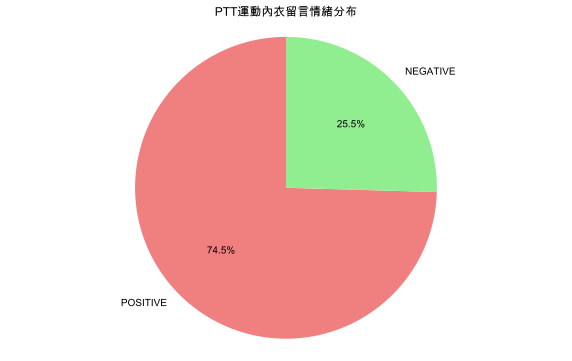

In [18]:
# 情緒分布圓餅圖
plt.figure(figsize=(10, 6))
plt.pie(ptt_sentiment_counts, labels=list(ptt_sentiment_counts.index), 
        autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
plt.axis('equal')
plt.title('PTT運動內衣留言情緒分布')
plt.show()